<a href="https://colab.research.google.com/github/maggieliuzzi/reinforcement_learning/blob/master/temporal_difference/control/Approximation_Semi_Gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Temporal Difference** | Control Problem | SARSA with Approximation, Semi-Gradient

In [0]:
from __future__ import print_function, division
from builtins import range
import matplotlib.pyplot as plt
import numpy as np
!wget "https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/rl/grid_world.py"
from grid_world import standard_grid, negative_grid
!wget "https://raw.githubusercontent.com/maggieliuzzi/reinforcement_learning/master/environments/utils.py"
from utils import print_values, print_policy

In [0]:
GAMMA = 0.9
ALPHA = 0.1
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
SA2IDX = {}
IDX = 0

In [0]:
def max_dict(d):
  # returns the argmax (key) and max (value) from a dictionary
  # put this into a function since we are using it so often
  max_key = None
  max_val = float('-inf')
  for k, v in d.items():
    if v > max_val:
      max_val = v
      max_key = k
  return max_key, max_val

In [0]:
def random_action(a, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    return a
  else:
    return np.random.choice(ALL_POSSIBLE_ACTIONS)

In [0]:
class Model:
  def __init__(self):
    self.theta = np.random.randn(25) / np.sqrt(25)
    # if we use SA2IDX, a one-hot encoding for every (s,a) pair
    # in reality we wouldn't want to do this b/c we have just
    # as many params as before
    # print "D:", IDX
    # self.theta = np.random.randn(IDX) / np.sqrt(IDX)

  def sa2x(self, s, a):
    # NOTE: using just (r, c, r*c, u, d, l, r, 1) is not expressive enough
    return np.array([
      s[0] - 1              if a == 'U' else 0,
      s[1] - 1.5            if a == 'U' else 0,
      (s[0]*s[1] - 3)/3     if a == 'U' else 0,
      (s[0]*s[0] - 2)/2     if a == 'U' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'U' else 0,
      1                     if a == 'U' else 0,
      s[0] - 1              if a == 'D' else 0,
      s[1] - 1.5            if a == 'D' else 0,
      (s[0]*s[1] - 3)/3     if a == 'D' else 0,
      (s[0]*s[0] - 2)/2     if a == 'D' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'D' else 0,
      1                     if a == 'D' else 0,
      s[0] - 1              if a == 'L' else 0,
      s[1] - 1.5            if a == 'L' else 0,
      (s[0]*s[1] - 3)/3     if a == 'L' else 0,
      (s[0]*s[0] - 2)/2     if a == 'L' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'L' else 0,
      1                     if a == 'L' else 0,
      s[0] - 1              if a == 'R' else 0,
      s[1] - 1.5            if a == 'R' else 0,
      (s[0]*s[1] - 3)/3     if a == 'R' else 0,
      (s[0]*s[0] - 2)/2     if a == 'R' else 0,
      (s[1]*s[1] - 4.5)/4.5 if a == 'R' else 0,
      1                     if a == 'R' else 0,
      1
    ])
    # if we use SA2IDX, a one-hot encoding for every (s,a) pair
    # in reality we wouldn't want to do this b/c we have just
    # as many params as before
    # x = np.zeros(len(self.theta))
    # idx = SA2IDX[s][a]
    # x[idx] = 1
    # return x

  def predict(self, s, a):
    x = self.sa2x(s, a)
    return self.theta.dot(x)

  def grad(self, s, a):
    return self.sa2x(s, a)

In [0]:
def getQs(model, s):
  # we need Q(s,a) to choose an action
  # i.e. a = argmax[a]{ Q(s,a) }
  Qs = {}
  for a in ALL_POSSIBLE_ACTIONS:
    q_sa = model.predict(s, a)
    Qs[a] = q_sa
    
  return Qs

In [13]:
grid = negative_grid(step_cost=-0.1)

print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [0]:
# no policy initialization, we will derive our policy from most recent Q
# enumerate all (s,a) pairs, each will have its own weight in our "dumb" model
# essentially each weight will be a measure of Q(s,a) itself
states = grid.all_states()
for s in states:
  SA2IDX[s] = {}
  for a in ALL_POSSIBLE_ACTIONS:
    SA2IDX[s][a] = IDX
    IDX += 1

# initialize model
model = Model()

In [15]:
# repeat until convergence
t = 1.0
t2 = 1.0
deltas = []
for it in range(20000):
  if it % 100 == 0:
    t += 0.01
    t2 += 0.01
  if it % 1000 == 0:
    print("it:", it)
  alpha = ALPHA / t2

  # instead of 'generating' an epsiode, we will PLAY
  # an episode within this loop
  s = (2, 0) # start state
  grid.set_state(s)

  # get Q(s) so we can choose the first action
  Qs = getQs(model, s)

  # the first (s, r) tuple is the state we start in and 0
  # (since we don't get a reward) for simply starting the game
  # the last (s, r) tuple is the terminal state and the final reward
  # the value for the terminal state is by definition 0, so we don't
  # care about updating it.
  a = max_dict(Qs)[0]
  a = random_action(a, eps=0.5/t) # epsilon-greedy
  biggest_change = 0
  while not grid.game_over():
    r = grid.move(a)
    s2 = grid.current_state()

    # we need the next action as well since Q(s,a) depends on Q(s',a')
    # if s2 not in policy then it's a terminal state, all Q are 0
    old_theta = model.theta.copy()
    if grid.is_terminal(s2):
      model.theta += alpha*(r - model.predict(s, a))*model.grad(s, a)
    else:
      # not terminal
      Qs2 = getQs(model, s2)
      a2 = max_dict(Qs2)[0]
      a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

      # we will update Q(s,a) AS we experience the episode
      model.theta += alpha*(r + GAMMA*model.predict(s2, a2) - model.predict(s, a))*model.grad(s, a)
      
      # next state becomes current state
      s = s2
      a = a2

    biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())
  deltas.append(biggest_change)

it: 0
it: 1000
it: 2000
it: 3000
it: 4000
it: 5000
it: 6000
it: 7000
it: 8000
it: 9000
it: 10000
it: 11000
it: 12000
it: 13000
it: 14000
it: 15000
it: 16000
it: 17000
it: 18000
it: 19000


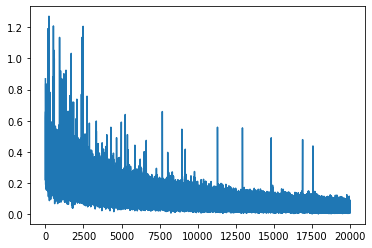

In [16]:
plt.plot(deltas)
plt.show()

In [0]:
# determine the policy from Q*
# find V* from Q*
policy = {}
V = {}
Q = {}
for s in grid.actions.keys():
  Qs = getQs(model, s)
  Q[s] = Qs
  a, max_q = max_dict(Qs)
  policy[s] = a
  V[s] = max_q

In [18]:
print("values:")
print_values(V, grid)
print("policy:")
print_policy(policy, grid)

values:
---------------------------
 0.55| 0.76| 0.99| 0.00|
---------------------------
 0.39| 0.00| 0.59| 0.00|
---------------------------
 0.22| 0.04| 0.18| 0.65|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  U  |  U  |  U  |
